---

<center><h2>Cargar librerias</h2></center>

---

In [1]:
#!pip install scikit-image

import os
import skimage
import cv2
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from skimage import io


In [2]:
#!pip uninstall skimage pandas numpy cv2 -y
#!pip install numpy

---

<center><h2>Leer imagenes del zip</h2></center>

---

In [3]:
def read_folder(path):
    files = [ os.path.join(path, file) for file in os.listdir(path) if file.endswith(".jpg") ]
    return sorted(files, key=lambda name: int(name.split("/")[-1][:-4]))

def to_imgs(imgs):
    return np.array([skimage.io.imread(x) for x in imgs])

X_files = read_folder("../zip/train/")
Y_files = read_folder("../zip/test/")

X_imgs = to_imgs(X_files)
Y_imgs = to_imgs(Y_files)

# Cluster al que corresponde cada carta en test.zip
y_clusters = [ int(x) for x in open("../zip/test_clusters.txt").read().split(", ") ]

---

<center><h2>Preprocesamiento de imagenes</h2></center>

---

In [4]:
def plot_image(img):
    skimage.io.imshow(img)

######################
# Plotting functions #
######################
def plot_comparison(imgs1, imgs2, row=0):
  fig, axs = plt.subplots(ncols=10, nrows=2, figsize=(30, 5))

  for x in range(10):
    axs[0][x].imshow(imgs1[row*10 + x])
 
  for x in range(10):
    axs[1][x].imshow(imgs2[row*10 + x])

def plot_10_rows(imgs):
    rows, cols = 10, 10
    fig, axs = plt.subplots(rows, cols, figsize=(30, 50))
    
    for y in range(rows):
        for x in range(cols):
            axs[y][x].imshow(imgs[rows*y + x])

##################
# File functions #
##################
def save_files(imgs, folder, files):
    files = [ f.split("/")[-1] for f in files ]
    
    for i, img in enumerate(imgs):
        cv2.imwrite(folder + files[i], img)

#save_files(X_imgs[:10], "../zip/test/", X_files)

In [5]:
##############################
# Cluster plotting functions #
##############################
def print_cluster_sizes(pred, y_clusters):
    print("Clusters:")
    for cluster in set(pred):
        print("  ", cluster, "size", len([_ for _ in pred if _ == cluster]))

    print("\nReal clusters:")
    for cluster in set(y_clusters):
        print("  ", cluster, "size", len([_ for _ in y_clusters if _ == cluster]))

    print()

def draw_clusters(imgs, pred):
    figheights = { 1: 5, 2: 7, 3: 10, 4: 15, 5: 16, 6: 20, 7: 25, 8: 28, 9: 30, 10: 35, 11: 40, 12: 45, 13: 50 }
    
    for targetClusterN in range(5):
        cluster_size = len([_ for _ in pred if _ == targetClusterN])
        nrows = cluster_size//10 + (1 if cluster_size%10 != 0 else 0)
        
        fig, axs = plt.subplots(ncols=10, nrows=nrows, figsize=(30, figheights[nrows]))
        fig.tight_layout()
        plt.figure(constrained_layout=True)
        
        # ax que va a tener el titulo
        title_ax = axs[0][0] if nrows > 1 else axs[0]
        title_ax.set_title("\nCluster " + str(targetClusterN) + "\n", fontsize=15)

        y, x = 0, 0

        for i, clusterN in enumerate(pred):
            if clusterN == targetClusterN:
                if nrows > 1: axs[y][x].imshow(imgs[i], aspect="auto")
                else: axs[x].imshow(imgs[i], aspect="auto")
                
                x += 1

            if x == 10:
                x = 0
                y += 1

In [12]:
############################
# Transformation functions #
############################

class Transformator:
    def __init__(self, img):
        self.img = img.copy()
        self.past = {}
    
    ################
    # Color spaces #
    ################
    def grayscale(self):
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        #self.img = cv2.cvtColor(self.img, cv2.COLOR_GRAY2BGR)
        
        return self
    
    def hsv(self):
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2HSV)
        
        return self
    
    def blur(self, val=(5, 5)):
        self.img = cv2.GaussianBlur(self.img, val, 0) # Parece funcionar bien
        #self.img = cv2.medianBlur(self.img, 5)
        #self.img = cv2.blur(self.img, val)
        #self.img = cv2.boxFilter(self.img, 5, 5) # No funciona
        
        #self.img = cv2.bilateralFilter(self.img, -1, 75, 75) # No termina
        
        return self
        
    def increase_contrast_brightness(self, contrast=1.0, brightness=0.0):
        self.img = contrast*self.img + brightness
        
        return self

    def increase_brightness(self, amt=20):
        hsv = cv2.cvtColor(self.img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
    
        lim = 255 - amt
        v[v > lim] = 255
        v[v <= lim] += amt

        final_hsv = cv2.merge((h, s, v))
        self.img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    
        return self
    
    def denoise(self):
        #gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        self.img = cv2.fastNlMeansDenoisingColored(self.img, None, 20, 7, 21)
        self.img = cv2.cvtColor(self.img, cv2.COLOR_RGB2BGR)
        #self.img = cv2.cvtColor(self.img, cv2.COLOR_GRAY2BGR)
        #sigma_est = skimage.restoration.estimate_sigma(self.img, channel_axis=-1, average_sigmas=True)
        #imgs = skimage.util.random_noise(imgs, var=0.1
        #self.img = skimage.restoration.denoise_tv_chambolle(self.img, weight=0.1, channel_axis=-1)
        
        return self
    
    # experimental
    def remove_empty_space(self, treshold, limit_x, limit_y):
        backup = self.img.copy()
        
        # Horizontal
        while self.img.shape[1] > limit_x:
            left_col = self.img[:, 0]
            pixel_set = set()
            
            for pixel in left_col:
                pixel_set.add(tuple(pixel))
                
            if len(pixel_set) < treshold:
                self.img = self.img[:, 1:]
            else:
                break
        
        # Vertical
        while self.img.shape[0] > limit_y:
            #print(self.img.shape)
            top_row = self.img[0, :]
            pixel_set = set()
            
            for pixel in top_row:
                pixel_set.add(tuple(pixel))
                
            if len(pixel_set) < treshold:
                self.img = self.img[1:, :]
            else:
                break
        
        if self.img.shape[0] == 0:
            self.img = backup
        
        return self

    # Oscurecer zonas fuera de un determinado umbral
    def treshold_test(self, amt=1):
        gray_img = skimage.color.rgb2gray(self.img)
        blurred_img = skimage.filters.gaussian(gray_img, sigma=1.0)
    
        t = skimage.filters.threshold_otsu(blurred_img)
    
        binary_mask = blurred_img > t
        selection = self.img
        selection[~binary_mask] = 0
    
        self.img = selection
        
        return self
    
    def threshold(self):
        gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        
        self.img = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
        
        return self
    
    def threshold_and(self):
        gray = cv2.cvtColor(self.img,cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

        self.img = cv2.bitwise_and(self.img, self.img, mask=thresh)
        
        return self

    # Invertir los colores si es predominantemente negra
    # No funciona mucho.
    def invert_if_black(self, treshold=150):
        avg_color = self.img.mean(axis=0).mean(axis=0)
        
        if avg_color[0] + avg_color[1] < treshold or avg_color[0]+avg_color[2] < treshold or avg_color[1]+avg_color[2] < treshold:
            self.img = cv2.bitwise_not(self.img)
        
        return self
    
    # TODO: Todavia no actualiza el histograma
    def equalize_histogram(self):
        # Contrast stretching
        percentile_2, percentile_98 = np.percentile(self.img, (0, 100))
        self.img = skimage.exposure.rescale_intensity(self.img, in_range=(percentile_2, percentile_98))
        
        #self.img = cv2.normalize(self.img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        #self.img = skimage.exposure.equalize_hist(self.img)
        
        return self
    
    def resize(self, h=100, w=100):
        self.img = cv2.resize(self.img, (w, h)) 
        
        return self

    # Normaliza la imagen entre 0 y 1
    def normalize(self):
        gray_img = skimage.color.rgb2gray(self.img)
        
        #self.img = (gray_img - np.min(gray_img)) / (np.max(gray_img) - np.min(gray_img))

        self.img = (self.img - np.min(self.img)) / (np.max(self.img) - np.min(self.img))
        
        return self
    
    def mask(self, black=([0, 0, 0], [100, 100, 100]), red=([80, 70, 50], [100, 255, 255])):
        img = self.img
        
        lower_black = np.array(black[0], dtype = "uint16")
        upper_black = np.array(black[1], dtype = "uint16")
        black_mask = cv2.inRange(img, lower_black, upper_black)

        lower_red = np.array(red[0], dtype = "uint16")
        upper_red = np.array(red[1], dtype = "uint16")
        red_mask  = cv2.inRange(img, lower_red, upper_red)

        # convert to LAB color space
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        # Perform Otsu threshold on the A-channel
        th = cv2.threshold(lab[:,:,2], 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        
        self.img = black_mask | th
        
        return self
    
    def remove_channel(self, channel=2):
        self.img[:,:,2] = np.zeros([self.img.shape[0], self.img.shape[1]])
        
        return self
    
    def sobel(self):
        self.img = skimage.filters.sobel(self.img)
        
        return self
    
    ########################
    # Morphology functions #
    ########################
    def erode(self):
        kernel = np.ones((5, 5), np.uint8)
        self.img = cv2.erode(self.img, kernel, iterations=1)

        return self
    
    def dilate(self):
        kernel = np.ones((5, 5), np.uint8)
        self.img = cv2.dilate(self.img,kernel,iterations = 1)

        return self
    
    # erosion followed by dilation
    def opening(self):
        kernel = np.ones((5, 5), np.uint8)
        self.img = cv2.morphologyEx(self.img, cv2.MORPH_OPEN, kernel)
        
        return self
    
    # dilation followed by erosion
    def closing(self):
        kernel = np.ones((5, 5), np.uint8)
        self.img = cv2.morphologyEx(self.img, cv2.MORPH_CLOSE, kernel)
        
        return self
    
    def gradient(self):
        kernel = np.ones((5, 5), np.uint8)
        self.img = cv2.morphologyEx(self.img, cv2.MORPH_GRADIENT, kernel)
        
        return self
    
    ################
    # Segmentation #
    ################
    def segmentate(self):
        img = self.img

        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

        # noise removal
        kernel = np.ones((3,3),np.uint8)
        opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

        # sure background area
        sure_bg = cv2.dilate(opening,kernel,iterations=3)

        # Finding sure foreground area
        dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
        ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

        # Finding unknown region
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg,sure_fg)

        # Marker labelling
        ret, markers = cv2.connectedComponents(sure_fg)
        # Add one to all labels so that sure background is not 0, but 1
        markers = markers+1
        # Now, mark the region of unknown with zero
        markers[unknown==255] = 0

        markers = cv2.watershed(img,markers)
        img[markers == -1] = [255,0,0]

        self.img = img
        
        return self
    
    ######################
    # Recortar la imagen #
    ######################
    def crop(self, x1, x2, y1, y2):
        size = 224
        self.img = self.img[y1:y2, x1:x2]
        #self.img = self.img[0:50, :] + self.img[size-50:, :]
        #self.img = self.img[:, 0:50] + self.img[:, size-50:]
        
        return self
    
    
    def transform_imgs(imgs):
        
    
        return self

In [19]:
from skimage import exposure
from skimage.color import rgb2gray
from skimage import filters

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def processY(filename: str= "../zip/test/") -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    X = mpimg.imread(filename)
    # <something gets done here>
    X = rgb2gray(X)
    thresh = filters.threshold_isodata(X)
    binary = X > thresh
    crop = binary[40:100,0:56]
    plt.figure()
    #plt.imshow(crop)
    return crop

def processX(filename: str= "../zip/train/") -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    X = mpimg.imread(filename)
    # <something gets done here>
    X = rgb2gray(X)
    thresh = filters.threshold_isodata(X)
    binary = X > thresh
    crop = binary[40:100,0:56]
    plt.figure()
    #plt.imshow(crop)
    return crop

#plt.rcParams['figure.max_open_warning'] = 300
Y = []
for file in Y_files:
    Y.append(process(file))


C:\Users\Sergio\AppData\Local\Temp\ipykernel_1580\1255945634.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
#fig, ax = filters.try_all_threshold(Y_imgs[1], figsize=(10, 10), verbose=False)
X = []
for file in X_files:
    X.append(processX(file))

---

<center><h2>Entrenar y predecir kmeans</h2></center>

---

ARI: -0.004981339191716878 

Clusters:
   0 size 7
   1 size 131
   2 size 31
   3 size 30
   4 size 66

Real clusters:
   0 size 65
   1 size 65
   2 size 65
   3 size 65
   4 size 5



KeyError: 14

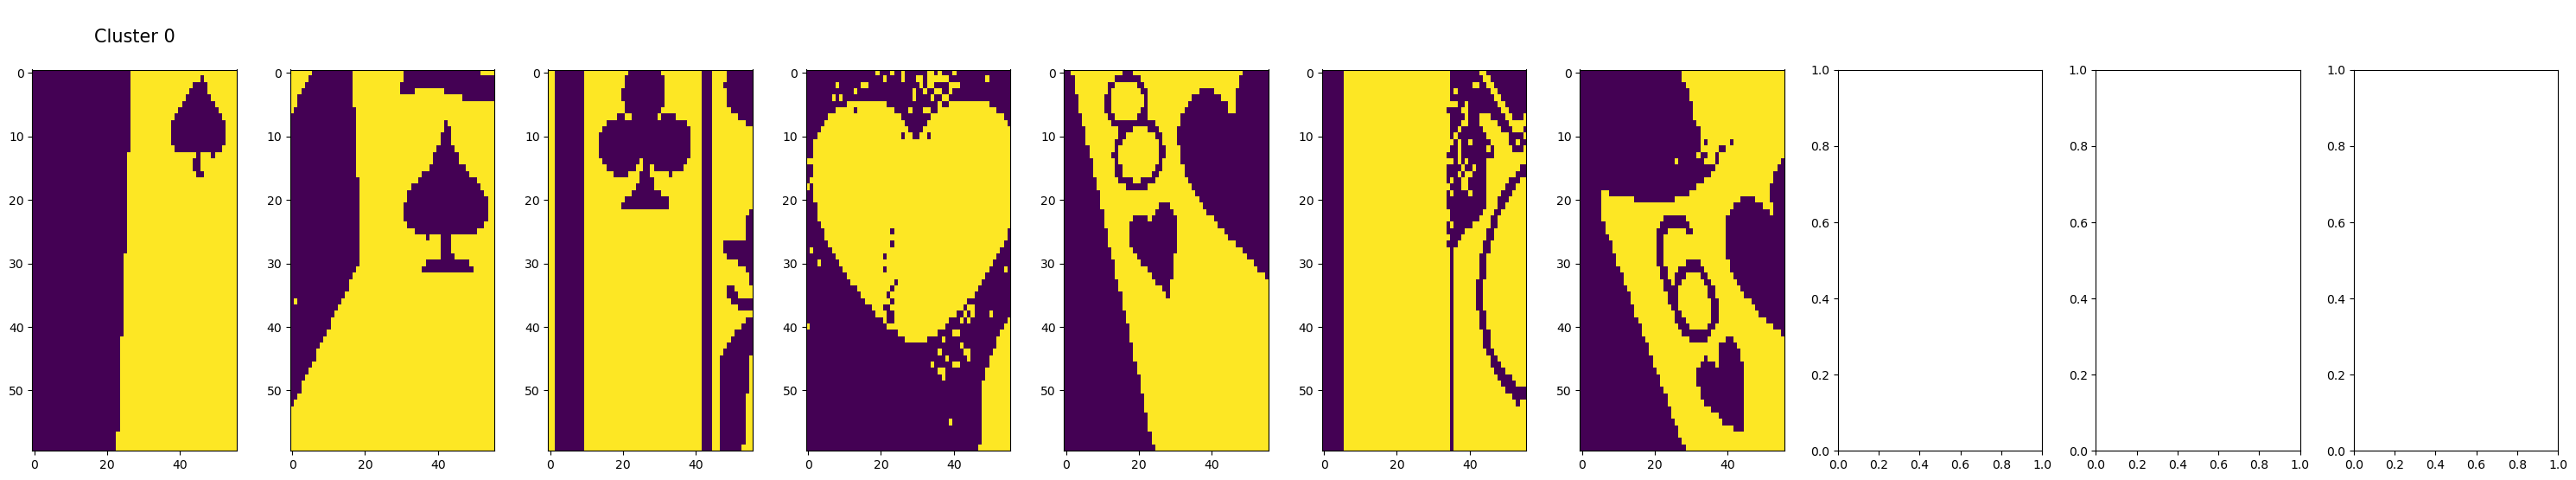

<Figure size 640x480 with 0 Axes>

In [24]:
# Convertir en arrays de una dimension
    
X_flat = np.array([x.flatten() for x in X])
Y_flat = np.array([y.flatten() for y in Y])

#--------------------------------------------------------------------------------------------

# 4 palos más el joker (0=treboles, 1=picas, 2=corazones, 3=diamantes, 5=joker)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_flat)

pred = kmeans.predict(Y_flat)

# ARI
# x=0-80, y=0-60 -> brightness=130 -> empty=10 -> hsv: 0.07203994977345117
# x=0-80, y=0-60 -> empty=10 -> hsv: 0.08121001181664109
# x=0-80, y=0-60 -> empty=10 -> equalize histogram (not) -> hsv -> normalize: ARI: 0.09604033793216146
# empty 10 -> crop 80/5-60 -> resize 40/40, equalize histogram (not) -> hsv -> normalize: ARI: 0.11339544956712676
# empty 10 -> crop 80/60 -> resize 40/40, equalize histogram (not) -> hsv -> normalize: ARI: 0.10612161862908516 
# ARI: 0.26160610896074815

#--------------------------------------------------------------------------------------------

ari = adjusted_rand_score(y_clusters, pred)
print("ARI:", ari, "\n")

print_cluster_sizes(pred, y_clusters)
draw_clusters(Y, pred) # Si se quieren ver las cartas originales sustituir por Y_imgs

---

<center><h2>CSV</h2></center>

---

In [11]:
ids = [y.split("/")[-1][:-4] for y in Y_files]
#print(Y_files[0].split())

solucion = pd.DataFrame(data = { "id" : ids, "suit": pred })
solucion.to_csv("solucion.csv", index=False)

In [12]:
solucion

,id,suit
0,37,2
1,65,1
2,91,1
3,106,2
4,130,1
...,...,...
260,7932,2
261,7935,2
262,8085,2
263,8102,1


---

<center><h2>Pruebas</h2></center>

---

In [ ]:
def draw_contours(_img):
    img = _img.copy()
    
    imgGry = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    gaussian = cv2.GaussianBlur(imgGry,(3,3),cv2.BORDER_DEFAULT)
    edges = cv2.Canny(gaussian,100,200)
    
    #_, treshold = cv2.threshold(imgGry, 127, 255, 0)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    #contour = max(contours, key = len)
 #    print(contours[2])

#    print(contour)

    for contour in contours:
        contourImg = cv2.drawContours(img, contour, -1, (0,255,0), 3)
    
    #for contour in contours:
    #    #print(contour)
    #    approx = cv2.approxPolyDP(contour, 0.01* cv2.arcLength(contour, True), True)
    #    cv2.drawContours(img, [approx], 0, (0, 0, 0), 2)
    
    return img

#plot_image(draw_contours(X_imgs[104]))

In [ ]:
IMG_SIZE = 224

crop_x1, crop_x2 = 0, 80
crop_y1, crop_y2 = 5, 60

resize_h, resize_w = 40, 40

treshold_empty_space = 10
brightness_lv = 130

# x = [ Transformator(img)
#         #.remove_empty_space(treshold=treshold_empty_space, limit_x=crop_x2, limit_y=crop_y2)
#         #.crop(crop_x1, crop_x2, crop_y1, crop_y2)
#         #.resize(h=resize_h, w=resize_w)
#         .mask(black=([0, 0, 0], [0, 0, 0]))
#         #.remove_channel(0)
#         #.remove_channel(1)
#         #.increase_contrast_brightness(contrast=1, brightness=0)
#         #.equalize_histogram()
#         .img
     
#      for img in X_imgs[:1000]
#]

# x = [ draw_contours(img) for img in Y_imgs ]

# for img in x:
#     for line in img:
#         for i, pixel in enumerate(line):
#             if not (pixel[1] == 255 and pixel[0] == 0 and pixel[2] == 0):
#                 line[i] = [0, 0, 0]

#x = [ Transformator(img).remove_channel(0).remove_channel(1).img for img in x ]
#x = [ Transformator(img).threshold_and().hsv().closing().closing().img for img in X_imgs[:100] ]
#save_files(x, "../zip/asdfasdf/", X_files)

In [ ]:
##################
# Flip if needed #
##################
# img = X_imgs[102]
# #w, h, = img.shape[0], img.shape[1]
# size = 224

# UL = img[0:100, 0:100]
# UR = img[0:100, size-100:size]
# DL = img[size-100:size, 0:100]
# DR = img[size-100:size, size-100:size]

# #UL = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# import statistics as stats

# #plot_image(UL)
# UL = list(UL.flatten())
# mean = stats.variance(UL)
# variance = sum([ abs(mean - x)**2 for x in UL ])/ len(UL)


# print(variance)

In [ ]:
# img = X_imgs[3]

# gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# # noise removal
# kernel = np.ones((3,3),np.uint8)
# opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# # sure background area
# sure_bg = cv2.dilate(opening,kernel,iterations=3)

# # Finding sure foreground area
# dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
# ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# # Finding unknown region
# sure_fg = np.uint8(sure_fg)
# unknown = cv2.subtract(sure_bg,sure_fg)

# # Marker labelling
# ret, markers = cv2.connectedComponents(sure_fg)
# # Add one to all labels so that sure background is not 0, but 1
# markers = markers+1
# # Now, mark the region of unknown with zero
# markers[unknown==255] = 0

# markers = cv2.watershed(img,markers)
# img[markers == -1] = [255,0,0]

# plot_image(img)

In [ ]:
#M = cv2.getRotationMatrix2D((112, 112), -45, 0.7)
#rotated = cv2.warpAffine(X_imgs[100], M, (224, 224))
#plot_image(rotated)